In [1]:
# Install required packages
!pip install  tensorflow

In [2]:
!pip install opencv-python


In [3]:
import zipfile
zfile = zipfile.ZipFile("archive (2).zip")
zfile.extractall()

In [4]:
import os , shutil
import random
import numpy as np
import pandas as pd
import cv2
import skimage
import matplotlib.pyplot as plt 
import skimage.segmentation
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [5]:
titles = ['PNEUMONIA' , 'NORMAL']
img_size = 128
def get_info(data_dir):
    data = []
    for title in titles:
        #train/pneumonia
        path = os.path.join(data_dir , title)
        class_num = titles.index(title) #givees the label 0 0r 1 to the pneumonia folder
        # Iterate through all files in the folder
        for img in os.listdir(path):
            try:
                # Skip hidden files and unsupported formats
                if img.startswith('.'):
                    continue
                
                # Get complete file path
                file_path = os.path.join(path, img)

                # Check if the file exists
                if not os.path.exists(file_path):
                    print(f"File not found: {file_path}")
                    continue

                # Skip unsupported file types
                if not (img.endswith(".jpg") or img.endswith(".png") or img.endswith(".jpeg")):
                    print(f"Skipping unsupported file: {file_path}")
                    continue
                 # Read the image in grayscale
                img_arr = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                
                # Check if image was loaded successfully
                if img_arr is None:
                    print(f"Unable to load image: {file_path}")
                    continue

                # Resize the image to the target size
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                
                # Append the resized image and label
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data , dtype=object)
    

In [6]:
train_images = get_info("chest_xray/chest_xray/train")
test_images = get_info("chest_xray/chest_xray/test")
val_images = get_info("chest_xray/chest_xray/val")

In [7]:
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"

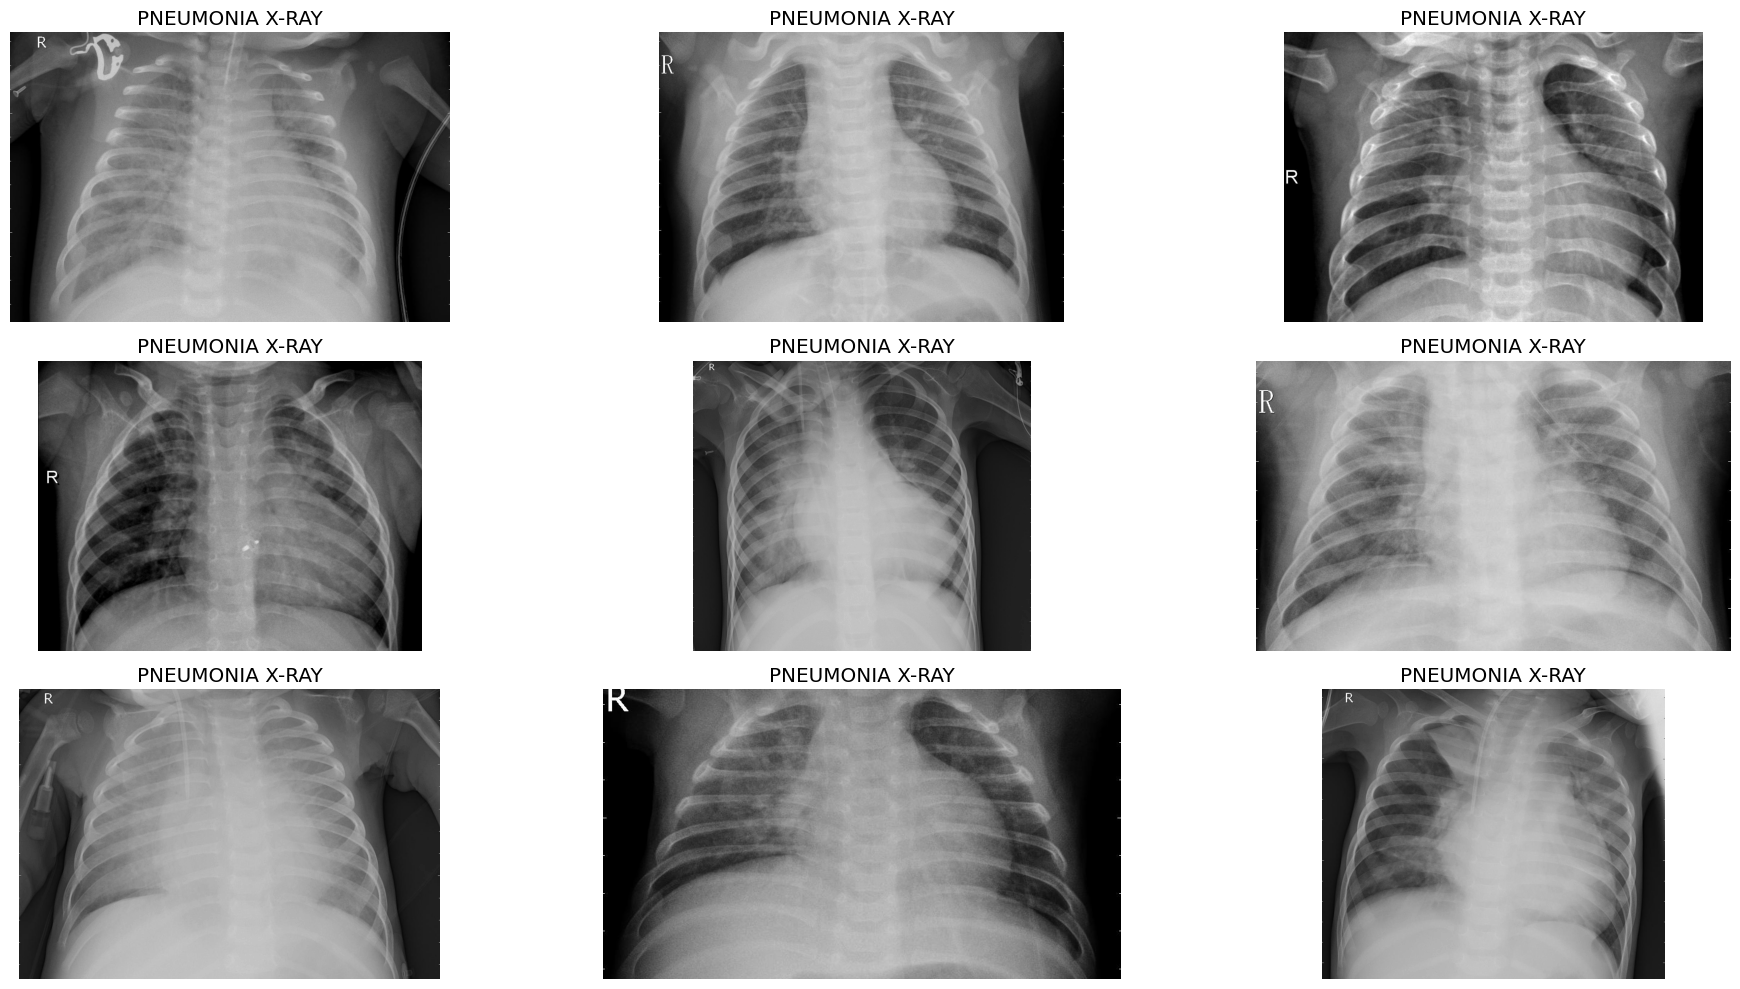

In [44]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(pneumonia_dir , pneumonia[i]))
    plt.imshow(img , cmap='gray')
    plt.axis("off")
    plt.title("PNEUMONIA X-RAY")
plt.tight_layout()
plt.show()

In [ ]:
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

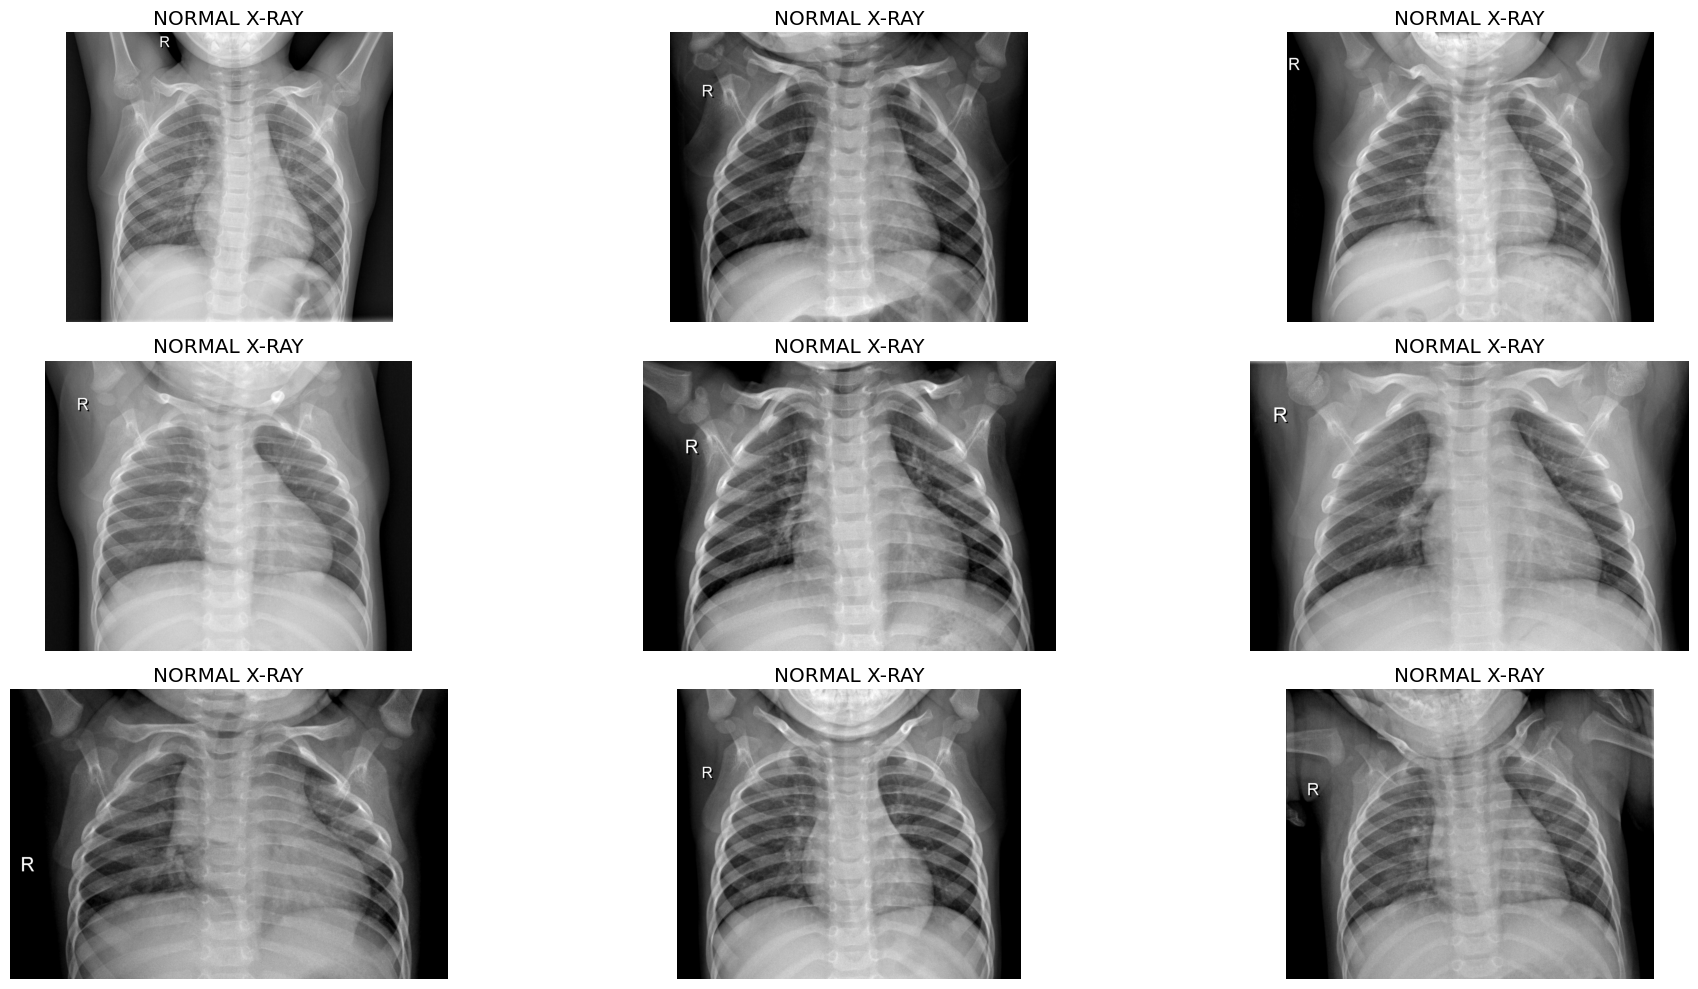

In [43]:
plt.figure(figsize=(20,10))

for i in range(9):
    plt.subplot(3,3, i+1)
    img = plt.imread(os.path.join(normal_dir , normal[i]))
    plt.imshow(img , cmap='gray')
    plt.axis("off")
    plt.title("NORMAL X-RAY")
plt.tight_layout()
plt.show()

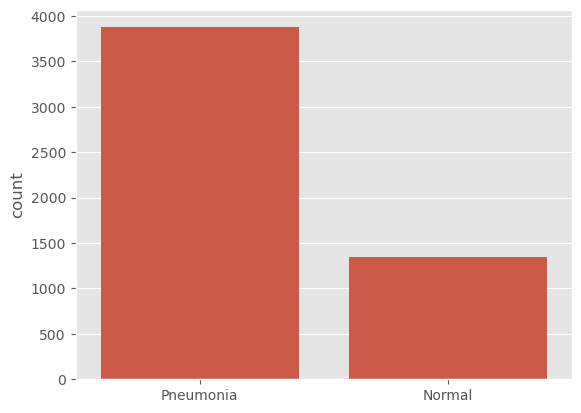

In [11]:
listp = []
for i in train_images:
    if(i[1] == 0):
        listp.append("Pneumonia")
    else:
        listp.append("Normal")
sns.countplot(x = listp) # taking   the p/n on x - axis
plt.show()

# The no of p images >> n images (imbalance)


# Data Augementation & resizing

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [3]:
train_generator = train_datagen.flow_from_directory(
    "chest_xray/chest_xray/train",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=True
)
valid_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/val",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False
)
test_generator = test_datagen.flow_from_directory(
    "chest_xray/chest_xray/test",
    batch_size=32,
    target_size=(128, 128),
    class_mode='categorical',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
class_labels = train_generator.class_indices

In [5]:
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [6]:
class_name = {value:key for(key , value) in class_labels.items()}

In [7]:
class_name  # will give normal for 0 and 1 for pneu

{0: 'NORMAL', 1: 'PNEUMONIA'}

# VGG19 CNN Architecture

In [8]:
# Load VGG19 Base Model
base_model = VGG19(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze initial layers except last 4 convolutional layers
for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False

# Add custom layers
x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation='relu', kernel_regularizer='l2')(flat)
bn1 = BatchNormalization()(class_1)
dropout1 = Dropout(0.3)(bn1)

class_2 = Dense(1152, activation='relu', kernel_regularizer='l2')(dropout1)
bn2 = BatchNormalization()(class_2)
dropout2 = Dropout(0.3)(bn2)

output = Dense(2, activation='softmax')(dropout2)

# Model Definition
model_01 = Model(base_model.inputs, output)
print(model_01.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,112,642 (240.76 MB)

 Trainable params: 52,515,970 (200.33 MB)

 Non-trainable params: 10,596,672 (40.42 MB)

None


In [9]:
# Callbacks
filepath = "model_weight/vgg19_model_01.h5"
es = EarlyStopping(monitor="val_loss", patience=8, mode="min", verbose=1, restore_best_weights=True)
cp = ModelCheckpoint(filepath, monitor="val_loss", save_best_only=True, mode="auto", save_weights_only=False)
lrr = ReduceLROnPlateau(monitor="val_loss", patience=3, verbose=1, factor=0.5, min_lr=1e-6)

In [10]:
#using adam as optimizer and class weights to reduce imbalance
adam = Adam(learning_rate=1e-4)

model_01.compile(loss="categorical_crossentropy", optimizer=adam, metrics=['accuracy'])

class_weight = {0: 1.0, 1: 1.5}  

In [11]:
#Model_Training
history_01 = model_01.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=50,
    class_weight=class_weight,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)

C:\Users\MANAV DHAWADE\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


C:\Users\MANAV DHAWADE\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7483 - loss: 72.8124

50/50 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - accuracy: 0.7495 - loss: 72.7148 - val_accuracy: 0.5000 - val_loss: 59.4321 - learning_rate: 1.0000e-04
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8880 - loss: 55.3722

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.8880 - loss: 55.3145 - val_accuracy: 0.6250 - val_loss: 47.4362 - learning_rate: 1.0000e-04
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8875 - loss: 44.9284

50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.8875 - loss: 44.8889 - val_accuracy: 0.6875 - val_loss: 39.9993 - learning_rate: 1.0000e-04
Epoch 4/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.8666 - loss: 38.9899

C:\Users\MANAV DHAWADE\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 286ms/step - accuracy: 0.8639 - loss: 38.6891 - val_accuracy: 0.8125 - val_loss: 37.9734 - learning_rate: 1.0000e-04
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8996 - loss: 36.2366

50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.8997 - loss: 36.2132 - val_accuracy: 0.6250 - val_loss: 34.9870 - learning_rate: 1.0000e-04
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9078 - loss: 31.6243

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9080 - loss: 31.6060 - val_accuracy: 0.8125 - val_loss: 29.1003 - learning_rate: 1.0000e-04
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9103 - loss: 28.1638

50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9104 - loss: 28.1487 - val_accuracy: 0.6250 - val_loss: 26.7082 - learning_rate: 1.0000e-04
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.9136 - loss: 25.6640 - val_accuracy: 0.6250 - val_loss: 26.7974 - learning_rate: 1.0000e-04
Epoch 9/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9239 - loss: 24.5299

50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9238 - loss: 24.5179 - val_accuracy: 0.7500 - val_loss: 23.3980 - learning_rate: 1.0000e-04
Epoch 10/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9374 - loss: 22.1549

50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9372 - loss: 22.1453 - val_accuracy: 0.7500 - val_loss: 21.6142 - learning_rate: 1.0000e-04
Epoch 11/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9443 - loss: 20.0763

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9442 - loss: 20.0673 - val_accuracy: 0.8125 - val_loss: 18.7859 - learning_rate: 1.0000e-04
Epoch 12/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 301ms/step - accuracy: 0.9632 - loss: 18.4713 - val_accuracy: 0.6250 - val_loss: 20.0777 - learning_rate: 1.0000e-04
Epoch 13/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9437 - loss: 17.7843

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9437 - loss: 17.7766 - val_accuracy: 0.7500 - val_loss: 16.9740 - learning_rate: 1.0000e-04
Epoch 14/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9469 - loss: 16.2149

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9469 - loss: 16.2081 - val_accuracy: 0.6875 - val_loss: 15.5461 - learning_rate: 1.0000e-04
Epoch 15/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9386 - loss: 14.8088

50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.9388 - loss: 14.8020 - val_accuracy: 0.7500 - val_loss: 14.3352 - learning_rate: 1.0000e-04
Epoch 16/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9399 - loss: 13.7674

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 322ms/step - accuracy: 0.9346 - loss: 13.7342 - val_accuracy: 0.6875 - val_loss: 14.0959 - learning_rate: 1.0000e-04
Epoch 17/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9340 - loss: 13.2143

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9340 - loss: 13.2086 - val_accuracy: 0.7500 - val_loss: 12.7836 - learning_rate: 1.0000e-04
Epoch 18/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9514 - loss: 12.0163

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9512 - loss: 12.0124 - val_accuracy: 0.8125 - val_loss: 11.4418 - learning_rate: 1.0000e-04
Epoch 19/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9319 - loss: 11.0688

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9320 - loss: 11.0642 - val_accuracy: 0.7500 - val_loss: 10.6385 - learning_rate: 1.0000e-04
Epoch 20/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9226 - loss: 10.2560

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.9318 - loss: 10.2221 - val_accuracy: 0.8750 - val_loss: 10.1402 - learning_rate: 1.0000e-04
Epoch 21/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9397 - loss: 9.8722

50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9397 - loss: 9.8680 - val_accuracy: 0.7500 - val_loss: 9.7905 - learning_rate: 1.0000e-04
Epoch 22/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9458 - loss: 9.0418

50/50 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - accuracy: 0.9459 - loss: 9.0375 - val_accuracy: 0.7500 - val_loss: 9.2757 - learning_rate: 1.0000e-04
Epoch 23/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9467 - loss: 8.2956

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9466 - loss: 8.2925 - val_accuracy: 0.7500 - val_loss: 8.8793 - learning_rate: 1.0000e-04
Epoch 24/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9212 - loss: 7.7573

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 323ms/step - accuracy: 0.9155 - loss: 7.7939 - val_accuracy: 0.7500 - val_loss: 8.3744 - learning_rate: 1.0000e-04
Epoch 25/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9501 - loss: 7.4070

50/50 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.9500 - loss: 7.4045 - val_accuracy: 0.7500 - val_loss: 7.6849 - learning_rate: 1.0000e-04
Epoch 26/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9403 - loss: 6.8244

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9404 - loss: 6.8215 - val_accuracy: 0.8125 - val_loss: 6.9960 - learning_rate: 1.0000e-04
Epoch 27/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9589 - loss: 6.2222

50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9587 - loss: 6.2203 - val_accuracy: 0.7500 - val_loss: 6.1207 - learning_rate: 1.0000e-04
Epoch 28/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9479 - loss: 5.8308

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 324ms/step - accuracy: 0.9402 - loss: 5.8341 - val_accuracy: 0.8125 - val_loss: 5.9225 - learning_rate: 1.0000e-04
Epoch 29/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9478 - loss: 5.6078

50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9480 - loss: 5.6051 - val_accuracy: 0.7500 - val_loss: 5.7026 - learning_rate: 1.0000e-04
Epoch 30/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9367 - loss: 5.1775 - val_accuracy: 0.6875 - val_loss: 5.8298 - learning_rate: 1.0000e-04
Epoch 31/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9513 - loss: 4.7299

50/50 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9512 - loss: 4.7281 - val_accuracy: 0.8125 - val_loss: 4.5248 - learning_rate: 1.0000e-04
Epoch 32/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 315ms/step - accuracy: 0.9480 - loss: 4.3854 - val_accuracy: 0.8750 - val_loss: 4.5797 - learning_rate: 1.0000e-04
Epoch 33/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9462 - loss: 4.2861 - val_accuracy: 0.6250 - val_loss: 5.6543 - learning_rate: 1.0000e-04
Epoch 34/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9409 - loss: 3.9598

50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9408 - loss: 3.9588 - val_accuracy: 0.6875 - val_loss: 4.0306 - learning_rate: 1.0000e-04
Epoch 35/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9454 - loss: 3.6221

50/50 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.9454 - loss: 3.6204 - val_accuracy: 0.8750 - val_loss: 3.4736 - learning_rate: 1.0000e-04
Epoch 36/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9634 - loss: 3.3538

50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 346ms/step - accuracy: 0.9656 - loss: 3.3391 - val_accuracy: 0.8750 - val_loss: 3.3160 - learning_rate: 1.0000e-04
Epoch 37/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9595 - loss: 3.2336 - val_accuracy: 0.6875 - val_loss: 3.6405 - learning_rate: 1.0000e-04
Epoch 38/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9561 - loss: 2.9605 - val_accuracy: 0.6875 - val_loss: 3.3769 - learning_rate: 1.0000e-04
Epoch 39/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.9645 - loss: 2.7046 
Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 897s 18s/step - accuracy: 0.9644 - loss: 2.7042 - val_accuracy: 0.7500 - val_loss: 3.5900 - learning_rate: 1.0000e-04
Epoch 40/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.9351 - loss: 2.6244

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 359ms/step - accuracy: 0.9440 - loss: 2.5835 - val_accuracy: 0.8125 - val_loss: 2.8245 - learning_rate: 5.0000e-05
Epoch 41/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9674 - loss: 2.4631

50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9673 - loss: 2.4628 - val_accuracy: 0.7500 - val_loss: 2.7003 - learning_rate: 5.0000e-05
Epoch 42/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9673 - loss: 2.3777 - val_accuracy: 0.7500 - val_loss: 2.9440 - learning_rate: 5.0000e-05
Epoch 43/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9615 - loss: 2.3014 - val_accuracy: 0.7500 - val_loss: 2.8251 - learning_rate: 5.0000e-05
Epoch 44/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 44:43 73s/step - accuracy: 0.9538 - loss: 2.2093
Epoch 44: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 873s 18s/step - accuracy: 0.9524 - loss: 2.2084 - val_accuracy: 0.7500 - val_loss: 2.9898 - learning_rate: 5.0000e-05
Epoch 45/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9617 - loss: 2.1624

50/50 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.9618 - loss: 2.1619 - val_accuracy: 0.8125 - val_loss: 2.4528 - learning_rate: 2.5000e-05
Epoch 46/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9642 - loss: 2.1237

50/50 ━━━━━━━━━━━━━━━━━━━━ 344s 7s/step - accuracy: 0.9643 - loss: 2.1230 - val_accuracy: 0.8125 - val_loss: 2.4137 - learning_rate: 2.5000e-05
Epoch 47/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.9576 - loss: 2.0850 

50/50 ━━━━━━━━━━━━━━━━━━━━ 509s 10s/step - accuracy: 0.9576 - loss: 2.0848 - val_accuracy: 0.8125 - val_loss: 2.2707 - learning_rate: 2.5000e-05
Epoch 48/50
13/50 ━━━━━━━━━━━━━━━━━━━━ 1:36 3s/step - accuracy: 0.9670 - loss: 2.0351

50/50 ━━━━━━━━━━━━━━━━━━━━ 1347s 793ms/step - accuracy: 0.9648 - loss: 2.0331 - val_accuracy: 0.8125 - val_loss: 2.1965 - learning_rate: 2.5000e-05
Epoch 49/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9558 - loss: 2.0512 - val_accuracy: 0.7500 - val_loss: 2.3904 - learning_rate: 2.5000e-05
Epoch 50/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9649 - loss: 1.9476

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9650 - loss: 1.9475 - val_accuracy: 0.9375 - val_loss: 2.0845 - learning_rate: 2.5000e-05
Restoring model weights from the end of the best epoch: 50.


In [12]:
# Save Model
model_01.save(filepath="model_weight/vgg19_model_01_final.h5", overwrite=True)  

In [13]:
# Evaluate Model on Validation and Test Set
vgg_val_eval_01 = model_01.evaluate(valid_generator)
vgg_test_eval_01 = model_01.evaluate(test_generator)

print(f"Validation Loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuracy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vgg_test_eval_01[0]}")
print(f"Test Accuracy: {vgg_test_eval_01[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step - accuracy: 0.9375 - loss: 2.0845
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 700ms/step - accuracy: 0.8626 - loss: 2.1047
Validation Loss: 2.0845084190368652
Validation Accuracy: 0.9375
Test Loss: 2.02441143989563
Test Accuracy: 0.9070512652397156


In [14]:
model_01.load_weights("model_weight/vgg19_model_01.h5")

# fine- tunning and unfreezing

In [15]:
for layer in base_model.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_conv4']:
        layer.trainable = True
    else:
        layer.trainable = False

# Compiling
adam_finetune = Adam(learning_rate=1e-5)
model_01.compile(loss="categorical_crossentropy", optimizer=adam_finetune, metrics=['accuracy'])

# Fine-Tuning Training
history_02 = model_01.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    class_weight=class_weight,
    callbacks=[es, cp, lrr],
    validation_data=valid_generator
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9678 - loss: 1.8652

50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.9678 - loss: 1.8644 - val_accuracy: 0.8750 - val_loss: 1.9053 - learning_rate: 1.0000e-05
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9699 - loss: 1.7020

50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9698 - loss: 1.7014 - val_accuracy: 0.8125 - val_loss: 1.8771 - learning_rate: 1.0000e-05
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9695 - loss: 1.5768 - val_accuracy: 0.7500 - val_loss: 1.9993 - learning_rate: 1.0000e-05
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 268ms/step - accuracy: 0.9619 - loss: 1.4925 - val_accuracy: 0.7500 - val_loss: 1.9492 - learning_rate: 1.0000e-05
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9649 - loss: 1.4737

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9650 - loss: 1.4730 - val_accuracy: 0.7500 - val_loss: 1.7553 - learning_rate: 1.0000e-05
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9681 - loss: 1.3887

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9680 - loss: 1.3891 - val_accuracy: 0.8125 - val_loss: 1.6406 - learning_rate: 1.0000e-05
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9736 - loss: 1.3068

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9734 - loss: 1.3071 - val_accuracy: 0.8125 - val_loss: 1.5462 - learning_rate: 1.0000e-05
Epoch 8/20
13/50 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.9795 - loss: 1.2438

50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 308ms/step - accuracy: 0.9787 - loss: 1.2383 - val_accuracy: 0.9375 - val_loss: 1.4210 - learning_rate: 1.0000e-05
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9800 - loss: 1.2187 - val_accuracy: 0.8125 - val_loss: 1.5034 - learning_rate: 1.0000e-05
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9728 - loss: 1.2110

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9728 - loss: 1.2106 - val_accuracy: 0.9375 - val_loss: 1.3279 - learning_rate: 1.0000e-05
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9770 - loss: 1.1619 - val_accuracy: 0.8125 - val_loss: 1.4311 - learning_rate: 1.0000e-05
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 278ms/step - accuracy: 0.9774 - loss: 1.0894 - val_accuracy: 0.7500 - val_loss: 1.5006 - learning_rate: 1.0000e-05
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9676 - loss: 1.1251

50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9677 - loss: 1.1247 - val_accuracy: 0.8125 - val_loss: 1.3108 - learning_rate: 1.0000e-05
Epoch 14/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9697 - loss: 1.0654

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9697 - loss: 1.0652 - val_accuracy: 0.9375 - val_loss: 1.1615 - learning_rate: 1.0000e-05
Epoch 15/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9759 - loss: 1.0287

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9758 - loss: 1.0287 - val_accuracy: 0.9375 - val_loss: 1.1449 - learning_rate: 1.0000e-05
Epoch 16/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 272ms/step - accuracy: 0.9680 - loss: 1.0114 - val_accuracy: 0.9375 - val_loss: 1.2420 - learning_rate: 1.0000e-05
Epoch 17/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9576 - loss: 1.0041

50/50 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.9577 - loss: 1.0039 - val_accuracy: 0.9375 - val_loss: 1.1185 - learning_rate: 1.0000e-05
Epoch 18/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9670 - loss: 0.9846

50/50 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - accuracy: 0.9670 - loss: 0.9843 - val_accuracy: 0.9375 - val_loss: 1.0641 - learning_rate: 1.0000e-05
Epoch 19/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9673 - loss: 0.9681 - val_accuracy: 0.7500 - val_loss: 1.1573 - learning_rate: 1.0000e-05
Epoch 20/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 276ms/step - accuracy: 0.9722 - loss: 0.9153 - val_accuracy: 0.9375 - val_loss: 1.0662 - learning_rate: 1.0000e-05
Restoring model weights from the end of the best epoch: 18.


In [16]:
model_01.save(filepath="model_weight/vgg19_finetuned.h5", overwrite=True)

In [17]:
# Evaluate Fine-Tuned Model
vgg_val_eval_02 = model_01.evaluate(valid_generator)
vgg_test_eval_02 = model_01.evaluate(test_generator)

print(f"Fine-Tuned Validation Loss: {vgg_val_eval_02[0]}")
print(f"Fine-Tuned Validation Accuracy: {vgg_val_eval_02[1]}")
print(f"Fine-Tuned Test Loss: {vgg_test_eval_02[0]}")
print(f"Fine-Tuned Test Accuracy: {vgg_test_eval_02[1]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 0.9375 - loss: 1.0641
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 691ms/step - accuracy: 0.8671 - loss: 1.1650
Fine-Tuned Validation Loss: 1.0640630722045898
Fine-Tuned Validation Accuracy: 0.9375
Fine-Tuned Test Loss: 1.0923019647598267
Fine-Tuned Test Accuracy: 0.9086538553237915


In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [23]:
model_01.load_weights("model_weight/vgg19_finetuned.h5")

In [24]:

test_generator.reset()

predictions = model_01.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

class_labels = list(test_generator.class_indices.keys())


20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 677ms/step


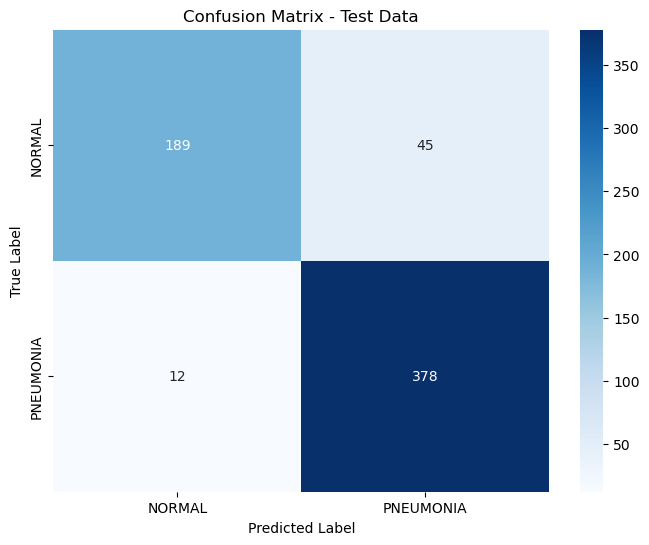

In [25]:
#Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Test Data")
plt.show()


In [26]:
#Classification Report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report for Test Data:\n", report)

Classification Report for Test Data:
               precision    recall  f1-score   support

      NORMAL       0.94      0.81      0.87       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



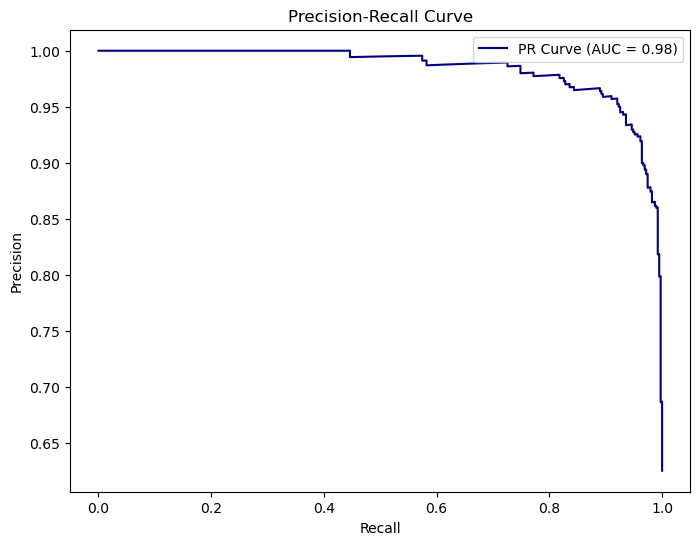

In [27]:
from sklearn.metrics import precision_recall_curve, auc

#Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(true_classes, predictions[:, 1])
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"PR Curve (AUC = {pr_auc:.2f})", color="navy")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()
